## 요약
- RF
- XGB
- NN

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 그래프의 폰트 출력을 선명하게 (svg, retina 등이 있음)
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("default")
# 이미지가 레이아웃 안으로 들어오도록 함
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
mpl.rcParams.update({"figure.constrained_layout.use": True})

#font, line, marker 등의 배율 설정: paper, notebook, talk, poster
sns.set_context("paper") 
#배색 설정: tab10, Set2, Accent, husl
sns.set_palette("Set2") 
#눈금, 배경, 격자 설정: ticks, white, whitegrid, dark, darkgrid
# withegrid: 눈금을 그리고, 각 축의 눈금을 제거
sns.set_style("whitegrid") 

In [2]:
# 로컬에서 

plt.rc("font", family = "D2Coding")
plt.rcParams["axes.unicode_minus"] = False

In [3]:
import os, natsort, re
from tqdm import tqdm
import time, random

In [4]:
PRJCT_PATH = '/home/doeun/code/AI/ESTSOFT2024/workspace/2.project_text/aladin_usedbook/'
save_dir = 'processed/model_input'
dir_path = os.path.join(PRJCT_PATH,save_dir)

In [5]:
import pickle

def load_pkl(file_path):
    with open(file_path,'rb') as f:
        data = pickle.load(f)

    return data

In [6]:
data_type = 'sample'
ver=0.75
X_train=load_pkl(os.path.join(dir_path,'{}.v{}_X_train.pkl'.format(data_type,ver)))
X_val=load_pkl(os.path.join(dir_path,'{}.v{}_X_val.pkl'.format(data_type,ver)))
X_test=load_pkl(os.path.join(dir_path,'{}.v{}_X_test.pkl'.format(data_type,ver)))
y_train=load_pkl(os.path.join(dir_path,'{}.v{}_y_train.pkl'.format(data_type,ver)))
y_val=load_pkl(os.path.join(dir_path,'{}.v{}_y_val.pkl'.format(data_type,ver)))
y_test=load_pkl(os.path.join(dir_path,'{}.v{}_y_test.pkl'.format(data_type,ver)))

In [7]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(44919, 69)

(11254, 69)

(14066, 69)

(44919, 1)

(11254, 1)

(14066, 1)

- remove SlsPrice

In [32]:
X_train_cropped = np.hstack([X_train[:,:-2],X_train[:,-1:]])
X_val_cropped = np.hstack([X_val[:,:-2],X_val[:,-1:]])
X_test_cropped = np.hstack([X_test[:,:-2],X_test[:,-1:]])

In [33]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [34]:
import sys
sys.path.append(PRJCT_PATH)

from module_aladin.reg_tool import *

In [35]:
make_reg_score_entire

<function module_aladin.reg_tool.make_reg_score_entire(dict_data, dict_rslt, print_rslt=False)>

## RF

In [36]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train_cropped,y_train)

/home/doeun/anaconda3/envs/EST_PRJ/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [37]:
y_pred1 = model_rf.predict(X_train_cropped)

In [38]:
display(y_pred1.shape)
display(y_train.shape)

(44919,)

(44919, 1)

In [39]:
make_reg_score_dict(y_pred1,y_train.reshape(-1),np.mean(y_train))

{'rmse': [234.60256179701486, 3946.3180266781515],
 'mape': [0.018368903273972458, 0.3347090364107699],
 'mase': [0.048577467496018566, 1],
 'r2_score': [0.9964658796176814, 0]}

In [40]:
y_pred2 = model_rf.predict(X_val_cropped)
make_reg_score_dict(y_pred2,y_val.reshape(-1),np.mean(y_val))

{'rmse': [633.7008507253788, 3974.7226815860968],
 'mape': [0.04548786064785258, 0.33488694895669946],
 'mase': [0.12306488899089567, 1],
 'r2_score': [0.9745812058588257, 0]}

In [41]:
y_pred3 = model_rf.predict(X_test_cropped)
make_reg_score_dict(y_pred3,y_test.reshape(-1),np.mean(y_test))

{'rmse': [572.0604259260485, 3698.5930556661483],
 'mape': [0.046563932591557444, 0.32818432197968755],
 'mase': [0.1274525268319637, 1],
 'r2_score': [0.9760772520134073, 0]}

In [42]:
dict_data = {
    'train':{'X':X_train_cropped,'y':y_train.reshape(-1)},
    'val':{'X':X_val_cropped,'y':y_val.reshape(-1)},
    'test':{'X':X_test_cropped,'y':y_test.reshape(-1)},
}
dict_rslt = {
    'train':y_pred1,
    'val':y_pred2,
    'test':y_pred3,
}


In [43]:
reg_score_dict = make_reg_score_entire(dict_data,dict_rslt,print_rslt=True)

train
r2 score : 0.99650
rmse_model : 234.60256 / rmse_base : 3966.74663	 mape_model : 0.01948 / mape_base : 0.33733	
------------------------------------------------------------------------------------------------------------------------------------------------------
val
r2 score : 0.97528
rmse_model : 633.70085 / rmse_base : 4030.87094	 mape_model : 0.05001 / mape_base : 0.33998	
------------------------------------------------------------------------------------------------------------------------------------------------------
test
r2 score : 0.97654
rmse_model : 572.06043 / rmse_base : 3734.80030	 mape_model : 0.04877 / mape_base : 0.33346	
------------------------------------------------------------------------------------------------------------------------------------------------------


In [44]:
def plot_reg_score(dict_data,dict_rslt,dict_score):
    fig,axes = plt.subplots(len(dict_data),3,figsize=(15,4*len(dict_data)))
    for n, (col,data) in enumerate(dict_data.items()):
        ax_row = axes[n] if len(dict_data) > 1 else axes
        ax1, ax2, ax3 = ax_row[0], ax_row[1], ax_row[2]
        y_actual, y_pred = (data['y'], dict_rslt[col])
        train_y = dict_data['train']['y']
        base_pred = np.mean(train_y)

        sns.histplot(y_actual,label='actual',ax=ax1,alpha=0.5)
        sns.histplot(y_pred,label='pred',ax=ax1,alpha=0.5)
        ax1.legend(fontsize=9)

        sns.histplot(y_actual-base_pred,ax=ax2, label = 'baseline',alpha=0.5)
        sns.histplot(y_actual-y_pred,ax=ax2, label = 'pred',alpha=0.5)
        ax2.legend(fontsize=9)
        ax2.set_title('distribution of errors',fontsize=10)

        df_score = pd.DataFrame(dict_score[col]).T[[1,0]]
        xs = list(chain.from_iterable(repeat(val,2) for val in df_score.index))
        ax3r = ax3.twinx()
        sns.barplot(x=xs[:2],y=list(df_score.values.reshape(-1))[:2],
                    hue = ['pred','base']*1,ax=ax3,alpha=0.65,legend=False)
        sns.barplot(x=xs[2:],y=list(df_score.values.reshape(-1))[2:],
                    hue = ['pred','base']*3,ax=ax3r,alpha=0.8,legend=False)
        ax3r.set_ylim([0.0,1.15])
        ax3r.bar_label(ax3r.containers[0], fontsize=8, fmt='%.4f')
        ax3r.bar_label(ax3r.containers[1], fontsize=8, fmt='%.4f')
        ax3.grid(False)
        ax3r.grid(False)
        ax3r.set_yscale('linear')    
        ax3.bar_label(ax3.containers[0], fontsize=8, fmt='%.4f')
        ax3.bar_label(ax3.containers[1], fontsize=8, fmt='%.4f')
        ax3.set_title('model score',fontsize=10)

        ax1.set_title(str_cutter(col+':distribution of data',50),fontsize=15,loc='left',ha='left')
        ax2.xaxis.set_label_coords(-0.02, -0.15)
        ax2.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>48}\n'.format(*dict_score[col]['rmse'],dict_score[col]['r2_score'][0],
            f'n = {len(y_actual)}'), fontsize=10,ha ='left')
        ax1.set_xlabel('')
        ax3.set_xlabel('')
        ax1.set_ylabel('count',fontsize =10) 
        ax2.set_ylabel('count',fontsize =10) 
        plt.setp(ax3.get_yticklabels(),rotation = 0, fontsize = 9, color='#333333')
        plt.setp(ax3r.get_yticklabels(),rotation = 0, fontsize = 9)

    for ax in axes.flatten():
        plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
        plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)

    return fig, axes

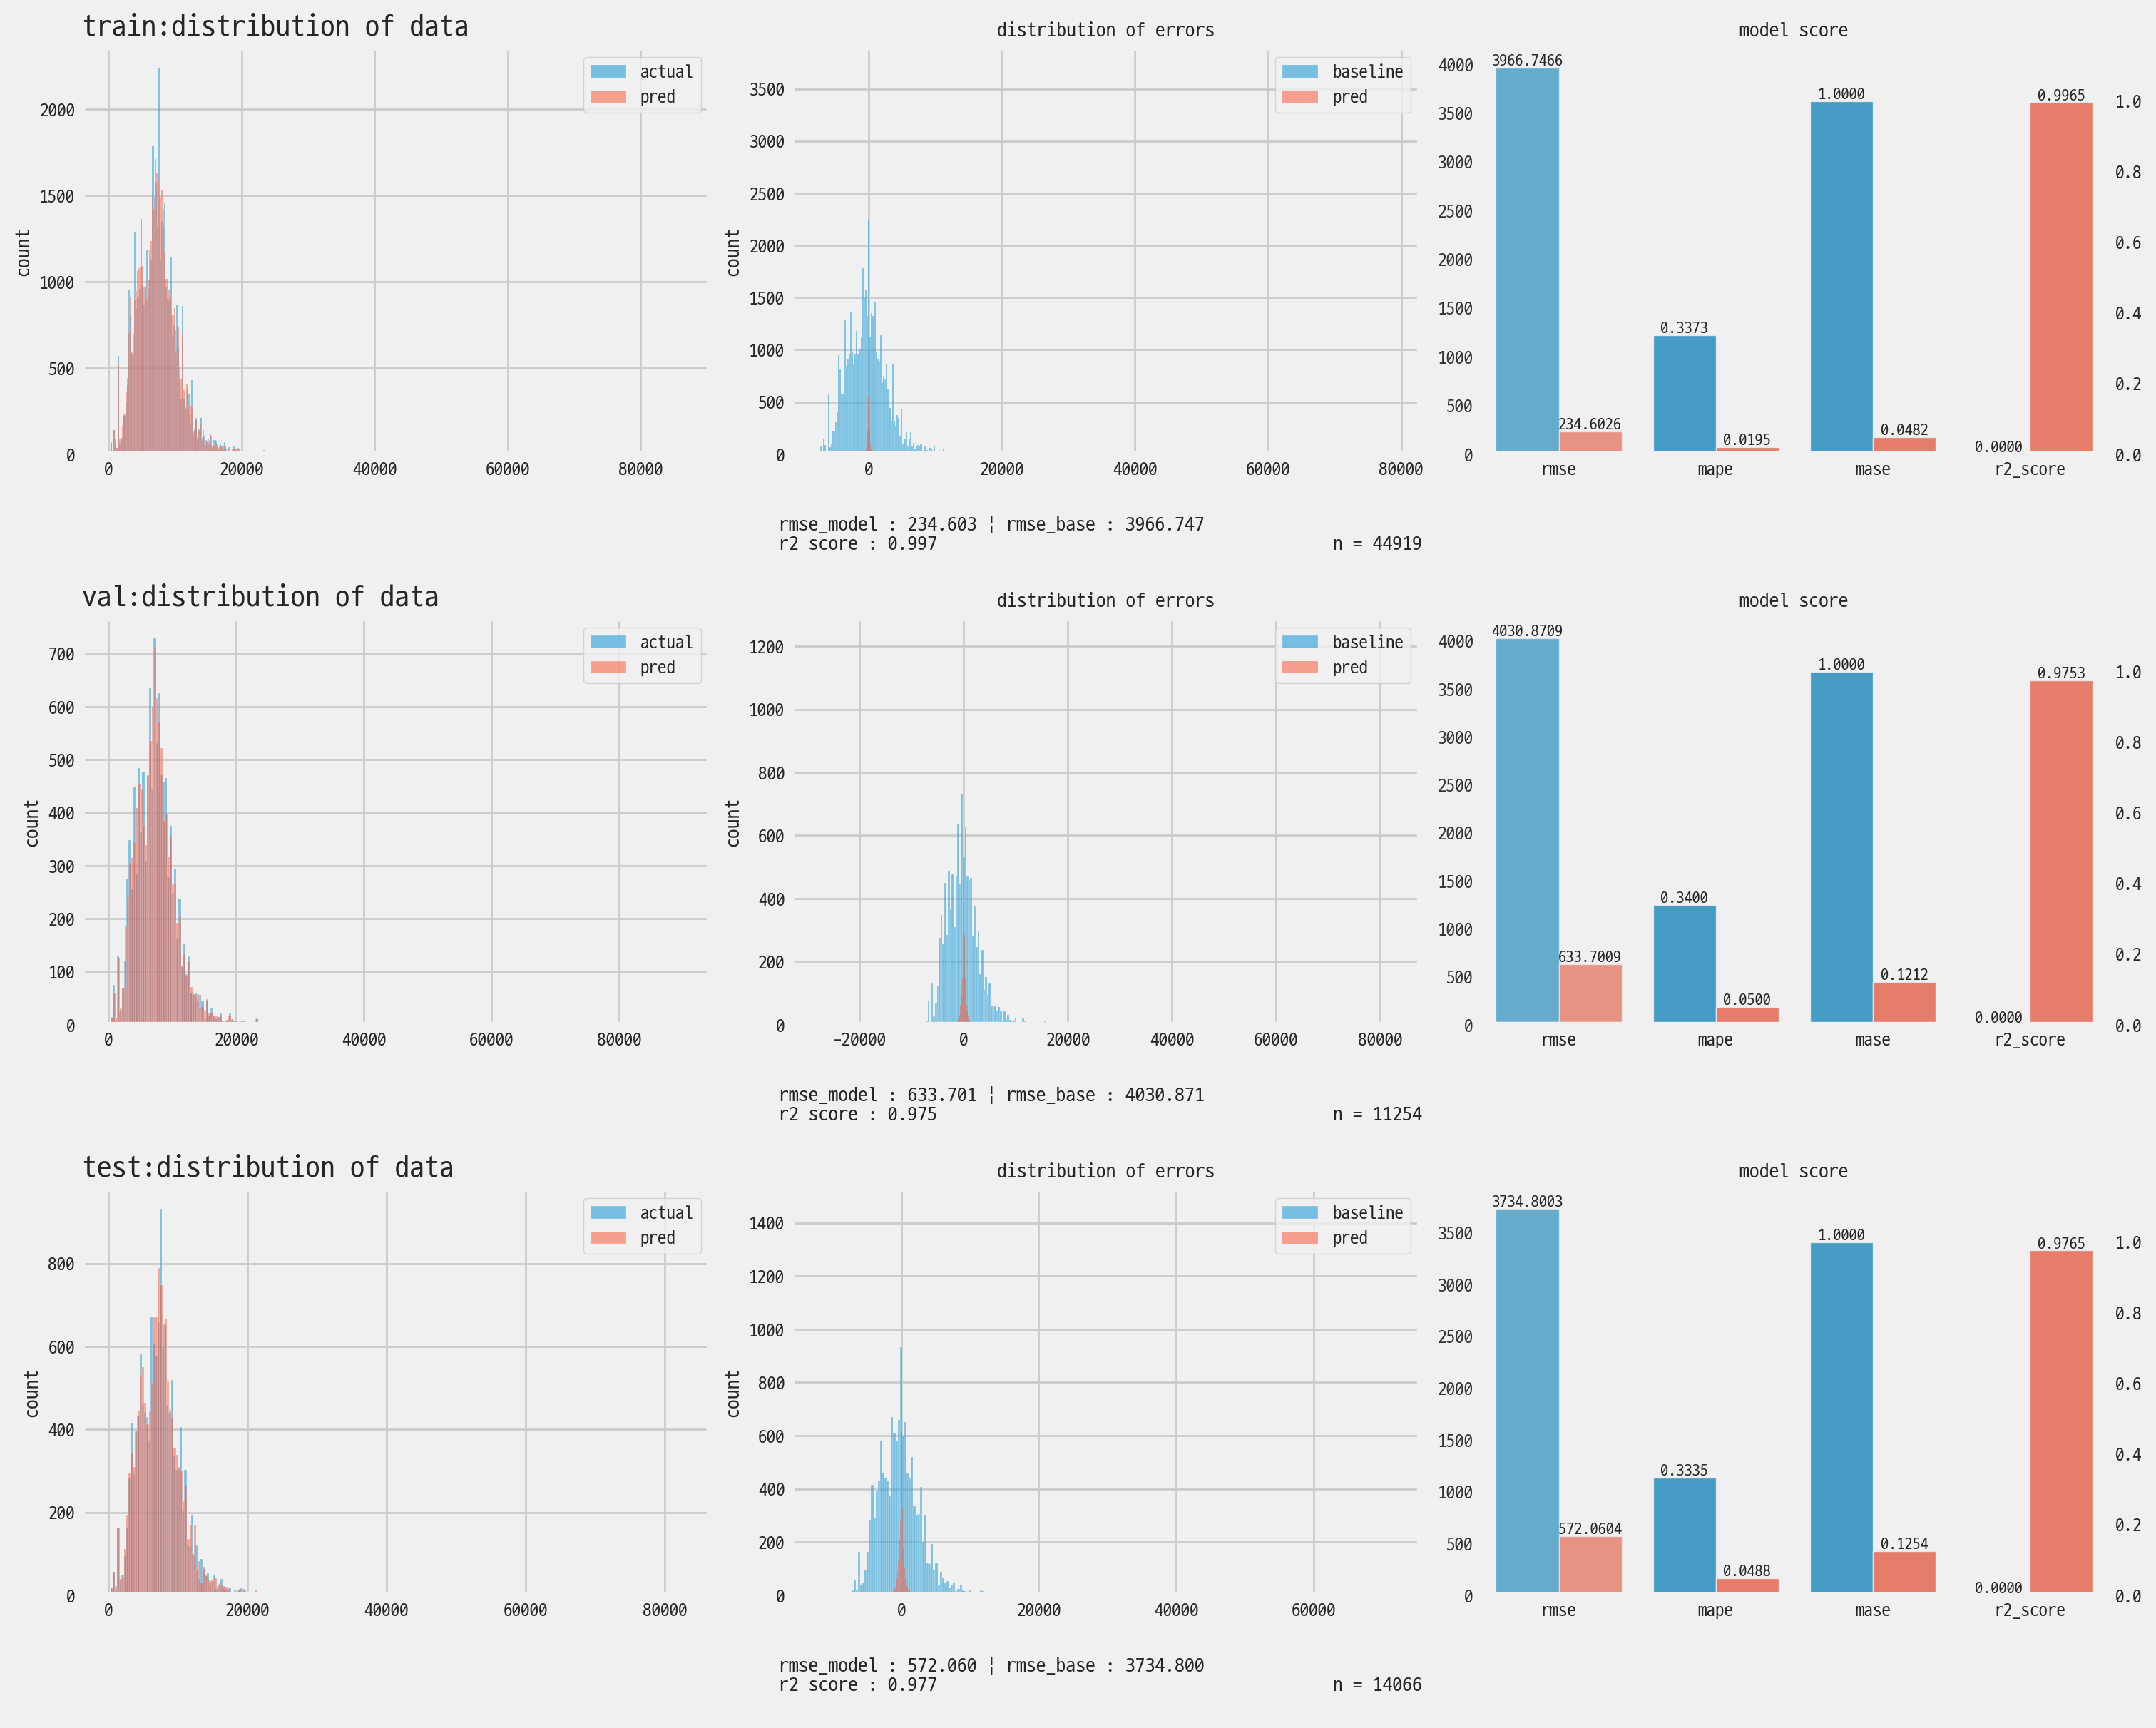

In [45]:
plot_reg_score(dict_data,dict_rslt,reg_score_dict);

In [46]:
rf_FI = model_rf.feature_importances_

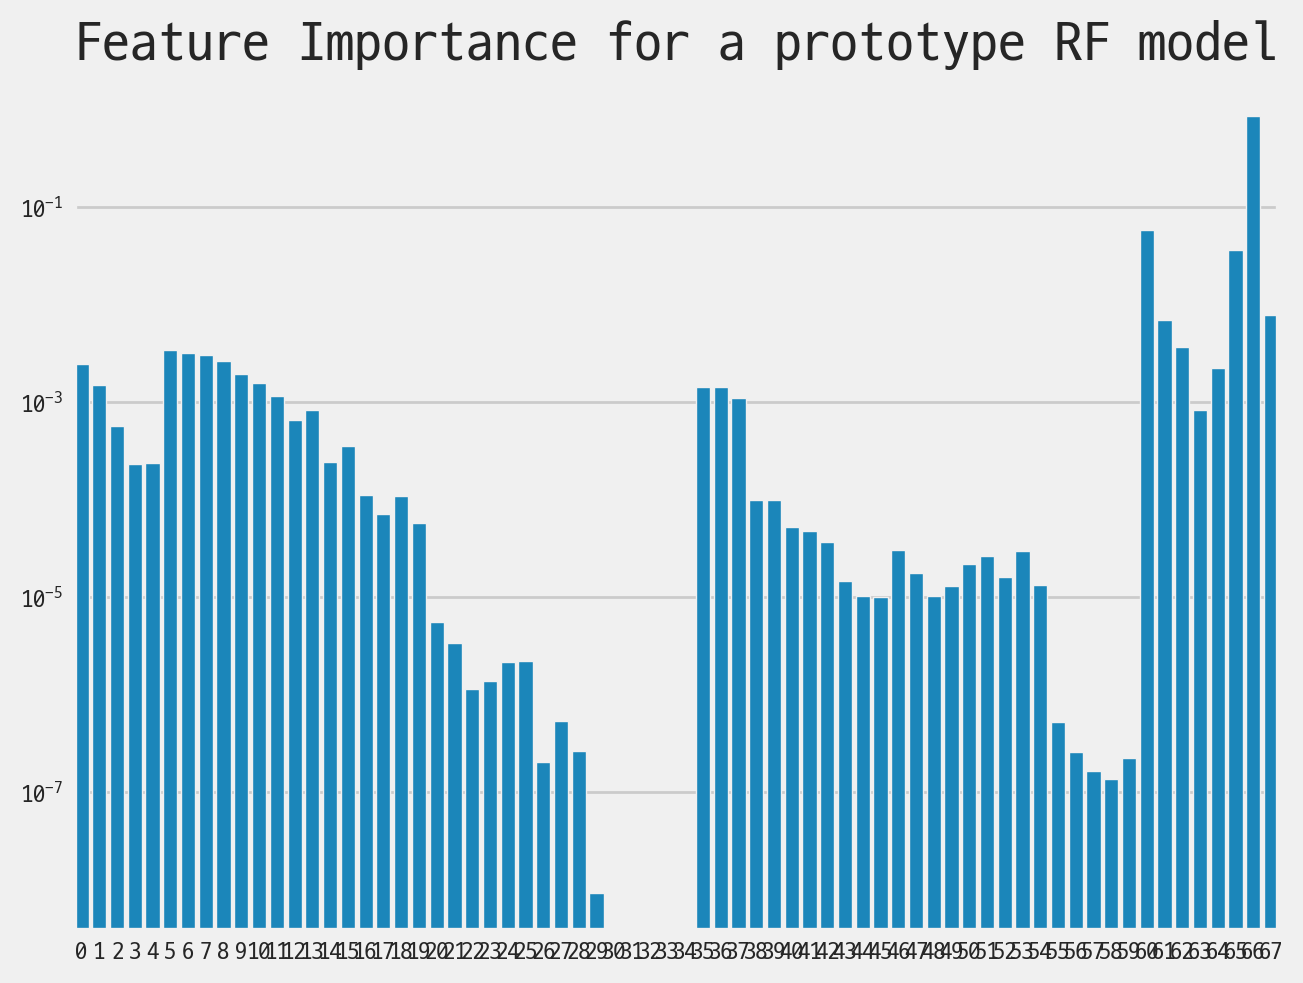

In [47]:
fig,ax = plt.subplots()
sns.barplot(rf_FI,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for a prototype RF model')
#ax.set_xticklabels([])
pass

- (0,5) : category
- (5,35) : BName
- (35,60) : BName_sub

In [48]:
col_vector = ['Category','BName','BName_sub']

In [49]:
col_scalar=['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
# 'SlsPrice',
 'SalesPoint']

In [50]:
col_partition = [(0,5),(5,35),(35,60)]+[(60+i,61+i) for i in range(len(col_scalar))]
col_partition

[(0, 5),
 (5, 35),
 (35, 60),
 (60, 61),
 (61, 62),
 (62, 63),
 (63, 64),
 (64, 65),
 (65, 66),
 (66, 67),
 (67, 68)]

In [51]:
cols_setting = list(zip(col_vector+col_scalar,col_partition))
concatted_FI = dict()
for (col,partition) in cols_setting:
    concatted_FI[col] = np.sum(rf_FI[partition[0]:partition[1]])
concatted_FI, sum(list(concatted_FI.values()))

({'Category': 0.004953038988746672,
  'BName': 0.01933411807936416,
  'BName_sub': 0.004473782785967316,
  'quality': 0.05832139855828539,
  'store': 0.007005449032829335,
  'Author': 0.00368913349978287,
  'Author_mul': 0.0008277331518391309,
  'Publshr': 0.002222856141738936,
  'Pdate': 0.03600217550988768,
  'RglPrice': 0.8554348777798971,
  'SalesPoint': 0.007735436471661328},
 0.9999999999999999)

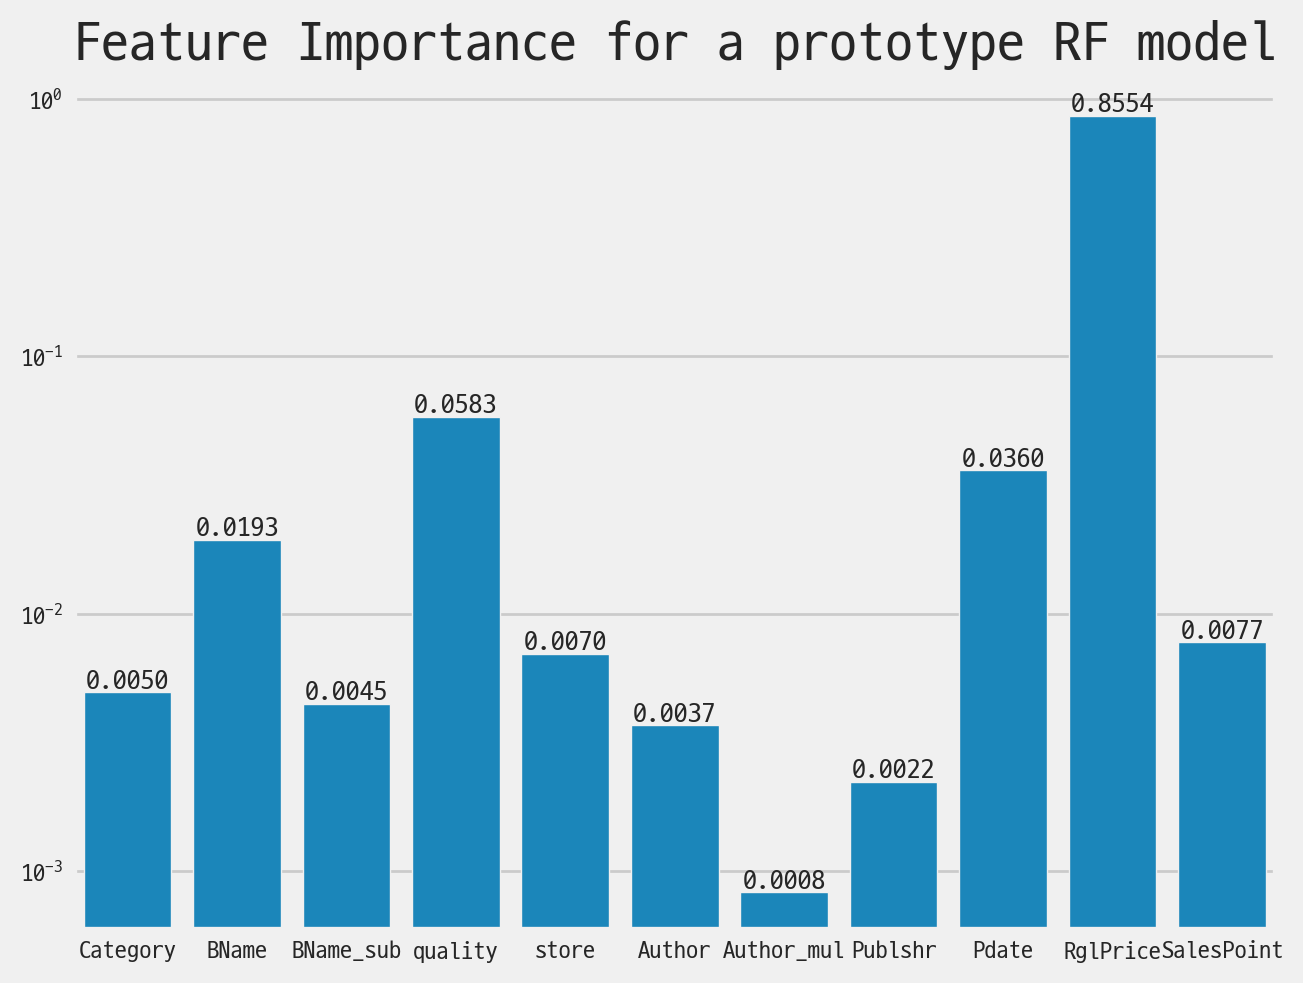

In [52]:
fig,ax = plt.subplots()
sns.barplot(concatted_FI,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for a prototype RF model')
ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
#ax.set_xticklabels([])
pass

<Axes: ylabel='Count'>

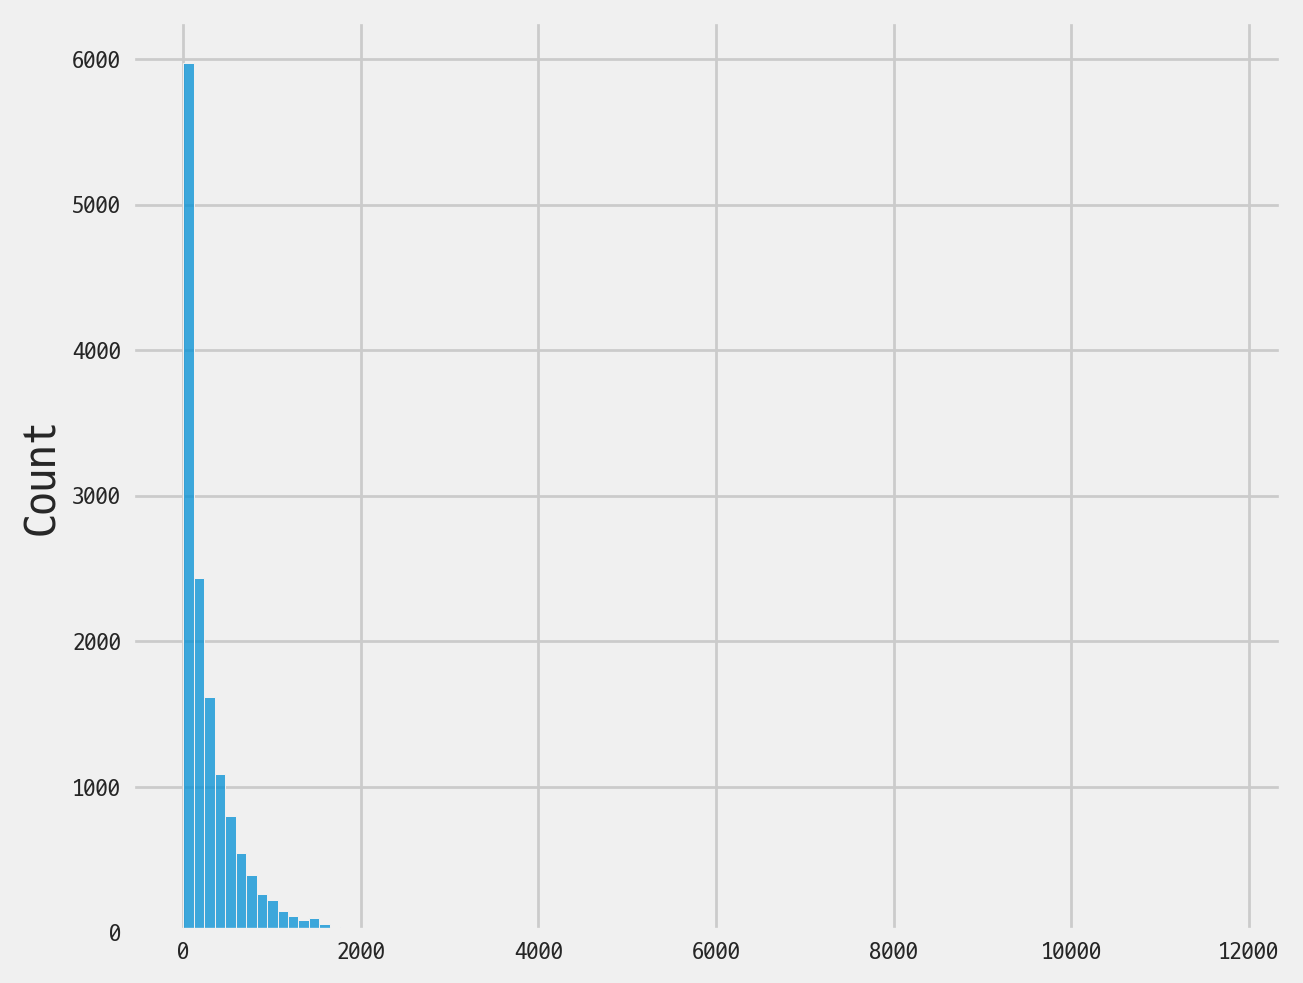

In [56]:
fig,ax = plt.subplots()
sns.histplot(np.abs(dict_data['test']['y']-dict_rslt['test']),ax=ax,bins=100)
#ax.set_yscale('log');

## XGB